## install the required modules

In [ ]:
%%capture
!pip install fasttext
!pip install -U sentence-transformers
!pip install -q laserembeddings
!pip install -q ftfy
!pip install datasets

## common functions

### visualisation and heat map

In [ ]:
import seaborn as sns
from sklearn.preprocessing import normalize
import numpy as np

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_, embed, do_normalize=True):
  message_embeddings_ = embed(messages_)
  if do_normalize:
      message_embeddings_ = normalize(message_embeddings_, norm='l2', axis=1)
  plot_similarity(messages_, message_embeddings_, 90)

### STS benchmark

In [ ]:
import pandas
import scipy
import math
import csv
import os
import tensorflow as tf

sts_dataset = tf.keras.utils.get_file(
    fname="Stsbenchmark.tar.gz",
    origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
    extract=True)
sts_dev = pandas.read_table(
    os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
    error_bad_lines=False,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
sts_test = pandas.read_table(
    os.path.join(
        os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
    error_bad_lines=False,
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
# cleanup some NaN values in sts_dev
sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]

import tensorflow as tf
from sklearn.preprocessing import normalize

def run_sts_benchmark(batch, embed, vectors='use'):
  """Returns the similarity scores"""
  if vectors == 'use':
    sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
    sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
  else:
      sts_encode1 = normalize(embed(batch['sent_1'].tolist()), norm='l2', axis=1)
      sts_encode2 = normalize(embed(batch['sent_2'].tolist()), norm='l2', axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  
  return scores

def compute_pearson(sts_data, embed_fn, vectors='use'):
  dev_scores = sts_data['sim'].tolist()
  scores = []
  for batch in np.array_split(sts_data, 10):
    scores.extend(run_sts_benchmark(batch, embed_fn, vectors))

  pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
  print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
        pearson_correlation[0], pearson_correlation[1]))

## Universal Sentence Encoder

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sent1 = "I am hungry"
sent2 = "I want to eat"

sent1 = embed([sent1])
sent2 = embed([sent2])

print('similarity:', cosine_similarity(sent1, sent2)[0][0])

similarity: 0.80750406


In [ ]:
from absl import logging

word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.03458564728498459, -0.017990127205848694, 0.0019805661868304014, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05833394080400467, -0.0818500965833664, 0.0689094141125679, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.026461755856871605, -0.01911565475165844, -0.042070381343364716, ...]



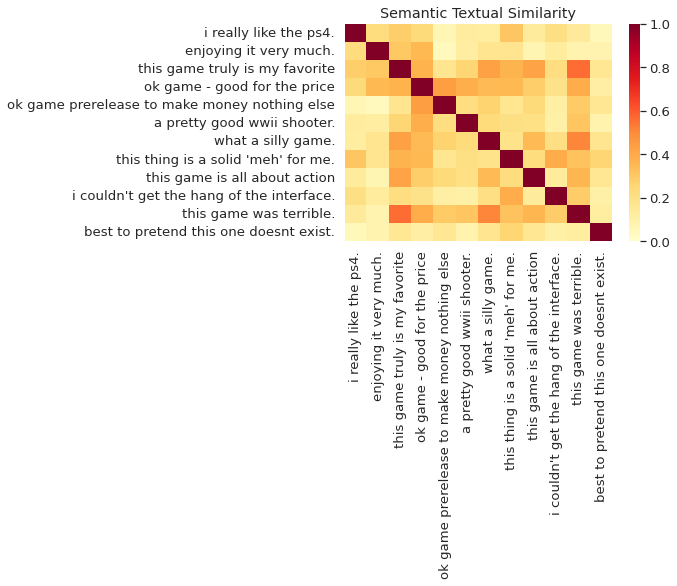

In [ ]:

messages = [
    # like this game
    "i really like the ps4.",
    "enjoying it very much.",
    "this game truly is my favorite",

    # ok game
    "ok game - good for the price",
    "ok game prerelease to make money nothing else",
    "a pretty good wwii shooter.",

    # meh!!
    "what a silly game.",
    "this thing is a solid 'meh' for me.",
    "this game is all about action",

    # did not like
    "i couldn't get the hang of the interface.",
    "this game was terrible.",
    'best to pretend this one doesnt exist.'
]

run_and_plot(messages, embed, do_normalize=False)

In [ ]:
compute_pearson(sts_dev, embed, vectors='use')

Pearson correlation coefficient = 0.8334392833010915
p-value = 0.0


## sentence bert embeddings

In [ ]:
messages = [
    # like this game
    "i really like the ps4.",
    "enjoying it very much.",
    "this game truly is my favorite",

    # ok game
    "ok game - good for the price",
    "ok game prerelease to make money nothing else",
    "a pretty good wwii shooter.",

    # meh!!
    "what a silly game.",
    "this thing is a solid 'meh' for me.",
    "this game is all about action",

    # did not like
    "i couldn't get the hang of the interface.",
    "this game was terrible.",
    'best to pretend this one doesnt exist.'
]

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embeddings = sbert_model.encode(messages)
print(sentence_embeddings)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-0.59219766 -0.27495492  1.6496987  ...  0.08997504  0.12087539
   0.23067702]
 [-0.15098281 -0.86201704  2.1980078  ...  0.60114163 -0.07572395
  -0.07055992]
 [-0.0302687   0.20668878  1.9889576  ...  0.30759805  0.01710184
   0.5438773 ]
 ...
 [ 0.66953665  0.1829109   1.5886942  ... -0.20632845 -0.6964833
   0.24636017]
 [ 0.31849745  0.12208287  1.5235137  ... -0.91165084  0.16632009
   0.34583285]
 [ 0.07395797  0.1937952   1.8678086  ...  0.29005542 -0.88554746
   0.37013587]]


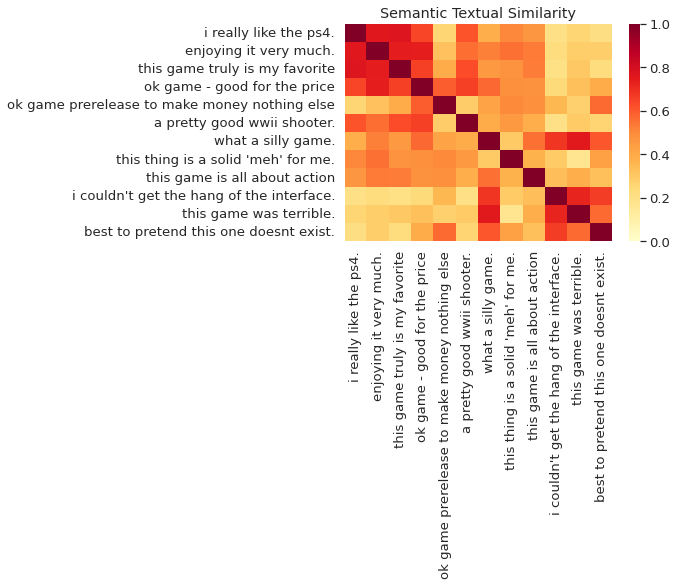

In [ ]:
run_and_plot(messages, sbert_model.encode)

In [ ]:
compute_pearson(sts_dev, sbert_model.encode, vectors='np')

Pearson correlation coefficient = 0.8059694038064068
p-value = 0.0


In [ ]:
sentence_embeddings[0].reshape(1, -1).shape

(1, 768)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(sentence_embeddings[0].reshape(1, -1), sentence_embeddings[1].reshape(1, -1))

array([[0.75839436]], dtype=float32)

## average glove based word embeddings

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/average_word_embeddings_glove.6B.300d')
embeddings = model.encode(sentences)
print(embeddings)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/164 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-2.64665008e-01 -2.26674005e-01 -3.47996980e-01 -2.62654990e-01
   1.97190508e-01 -9.14949998e-02  2.47254997e-01 -4.24465001e-01
  -2.78364986e-01 -1.52365005e+00  1.21467993e-01  1.36302505e-02
  -3.94914985e-01  1.76838502e-01 -3.47050056e-02 -2.98945010e-01
  -1.14455998e-01 -2.27650031e-02 -1.51705846e-01 -4.99460012e-01
   1.65081993e-01 -1.47114992e-01  1.13208249e-01  2.10548490e-01
  -1.52712509e-01 -3.78019989e-01  4.16520014e-02 -3.06959987e-01
  -1.23482503e-01 -2.67659992e-01 -3.69657487e-01  5.36225021e-01
  -4.02254999e-01  1.31069988e-01 -7.51799941e-02 -2.85070002e-01
  -1.03549957e-02 -4.88460004e-01 -3.78574997e-01  2.42608503e-01
   4.61874485e-01  3.69210020e-02 -3.33090007e-01  1.46139994e-01
  -1.51894510e-01 -1.09146953e-01 -4.75178987e-01  5.64700007e-01
   3.96899953e-02 -6.06149994e-02 -2.58730024e-01 -1.20144993e-01
   2.95935005e-01  2.06270009e-01  1.00895002e-01 -1.57559980e-02
  -1.20039999e-01 -3.19000006e-01  1.16341501e-01 -1.28049999e-02
   5.83079

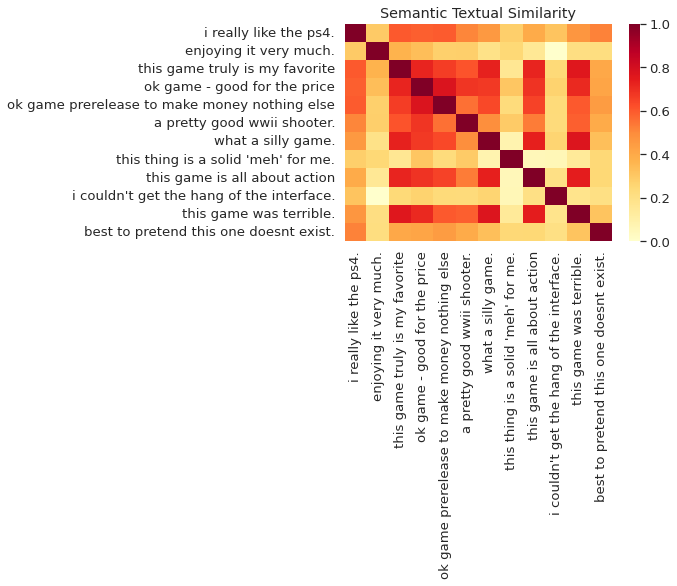

In [ ]:
run_and_plot(messages, model.encode)

In [ ]:
compute_pearson(sts_dev, model.encode, vectors='np')

Pearson correlation coefficient = 0.716020665445073
p-value = 4.243981984651061e-231


## cross lingual sentence embeddings

### laser embeddings

In [ ]:
!python -m laserembeddings download-models


✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [ ]:
from laserembeddings import Laser

laser = Laser()

# if all sentences are in the same language:

embeddings = laser.embed_sentences(
    ['let your neural network be polyglot',
     'use multilingual embeddings!'],
    lang='en')  # lang is only used for tokenization

In [ ]:
from typing import List, Union
import numpy as np

def laser_encode(text: Union[str, List[str]], lang='en', normalize=True) -> np.ndarray:
    """
    Encodes a corpus of text using LASER
    :param text: Large block of text (will be tokenized), or list of pre-tokenized sentences
    :param lang: 2 digit language code (optional autodetect)
    :return:     embedding matrix
    """
    laser_model = Laser()
    
    if isinstance(text, str):
        sentences = [ text ]
    else:
        sentences = list(text)

    embedding = laser_model.embed_sentences(sentences, lang=lang)
    
    if normalize:
        embedding = embedding / np.sqrt(np.sum(embedding**2, axis=1)).reshape(-1,1)
        
    return embedding

embedding = laser_encode('let your neural network be polyglot')
print(embedding.shape)

(1, 1024)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

emb1 = laser_encode('Ein kleines Kind reitet auf einem Pferd.', lang='de')
emb2 = laser_encode('Ein Kind reitet auf einem Pferd.', lang='de')

cosine_similarity(emb1, emb2)

array([[0.977347]], dtype=float32)

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset_de = load_dataset("stsb_multi_mt", name="de", split="dev")
dataset_en = load_dataset("stsb_multi_mt", name="en", split="dev")
dataset_de_df = dataset_de.to_pandas()
dataset_de_df['lang'] = 'de'
dataset_en_df = dataset_en.to_pandas()
dataset_en_df['lang'] = 'en'
dataset_df = pd.concat([dataset_de_df, dataset_en_df])

dataset_df = dataset_df.rename(columns={'sentence1': 'sent_1', 'sentence2': 'sent_2', 'similarity_score': 'sim'})

dataset_df.sample(10)

Downloading:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/270k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.5k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/de/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.9k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


,sent_1,sent_2,sim,lang
112,Eine Balletttänzerin tritt auf der Bühne auf.,Der Biber wird gestreichelt.,0.00,de
929,"Ich begann die Stargate-Serie, indem ich mir z...",Ohne mich in eine eingehende Analyse von Atlan...,1.80,de
394,Ein schwarzer Hund läuft hinter einem weißen H...,Schwarzer Hund jagt braunen Hund durch Schnee,1.80,de
949,"To play golf, the first thing you need is a se...",Having fairly recently taken up the sport myse...,1.20,en
849,"Nun, zum einen könnte ein Wesen eine nicht-phy...","Der Unterschied ist enorm, da nicht alle nicht...",3.40,de
1109,"Das Gremium wies das Handelsministerium an, in...","Er forderte das Handelsministerium auf, innerh...",2.60,de
490,Two dogs are running on the grass in front of ...,A brown dog is running on the grass in front o...,2.80,en
1302,EU setzt auf neue Sanktionen gegen Iran,EU plant umfangreiche neue Sanktionen gegen de...,4.40,de
146,Ein Mann rennt.,Ein Mann singt.,1.25,de
262,Roter Doppeldeckerbus fährt eine Straße entlang.,Ein roter zweistöckiger Bus fährt die Straße e...,3.80,de


In [ ]:
import seaborn as sns
from sklearn.preprocessing import normalize
import numpy as np

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot_laser(messages_, langs, embed=None):
  message_embeddings_ = normalize(embed(messages_, langs), norm='l2', axis=1)
#   print(message_embeddings_.shape)
  plot_similarity(messages_, message_embeddings_, 90)

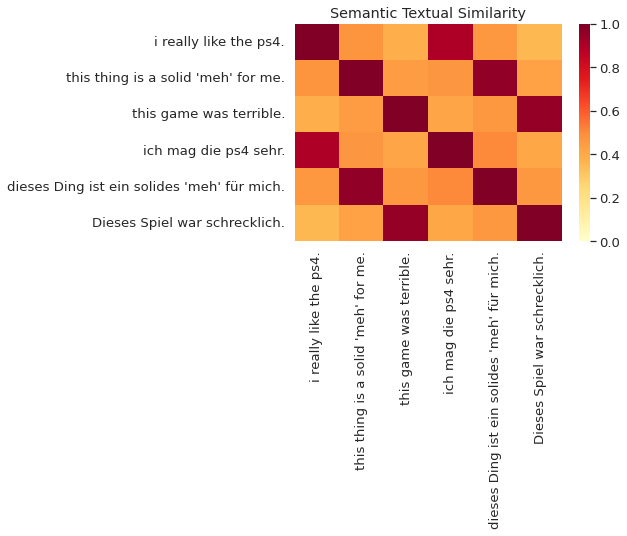

In [ ]:
messages = [
    # english
    "i really like the ps4.",
    "this thing is a solid 'meh' for me.",
    "this game was terrible.",

    # de
    "ich mag die ps4 sehr.",
    "dieses Ding ist ein solides 'meh' für mich.",
    "Dieses Spiel war schrecklich.",
]

langs = ['en'] * 3 + ['de'] * 3

run_and_plot_laser(messages, langs, laser_encode)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import normalize

def run_sts_benchmark_laser(batch, embed, vectors='use'):
  """Returns the similarity scores"""
  if vectors == 'use':
    sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
    sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
  else:
      sts_encode1 = normalize(embed(batch['sent_1'].tolist()), norm='l2', axis=1)
      sts_encode2 = normalize(embed(batch['sent_2'].tolist()), norm='l2', axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  
  return scores

def compute_pearson_laser(sts_data, embed_fn, vectors='use'):
  dev_scores = sts_data['sim'].tolist()
  scores = []
  for batch in np.array_split(sts_data, 10):
    scores.extend(run_sts_benchmark_laser(batch, embed_fn, vectors))

  pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
  print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
        pearson_correlation[0], pearson_correlation[1]))
  
compute_pearson_laser(dataset_df, laser_encode, vectors='np') # 0.729461283480811

Pearson correlation coefficient = 0.7295386988356121
p-value = 0.0


In [ ]:
compute_pearson_laser(sts_dev, laser_encode, vectors='np') # 0.7176004045918506

Pearson correlation coefficient = 0.7176004045918506
p-value = 1.3929180945590954e-232


### XLM ROberta model

In [ ]:
from sentence_transformers import SentenceTransformer

sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
embeddings = model.encode(sentences)
print(embeddings)

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/709 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-0.26997402  0.08224897  1.4262304  ... -0.43902254 -1.2129794
   0.06791177]
 [ 0.4495459   0.34814423  1.2075766  ...  0.16226198  0.31875896
   0.18042585]]


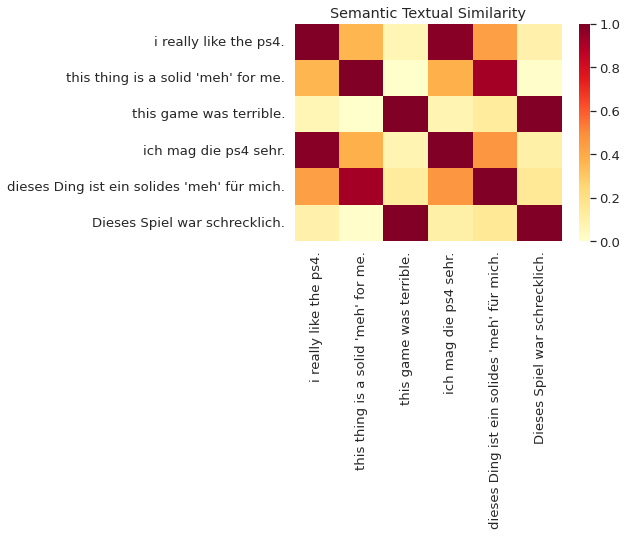

In [ ]:
messages = [
    # english
    "i really like the ps4.",
    "this thing is a solid 'meh' for me.",
    "this game was terrible.",

    # de
    "ich mag die ps4 sehr.",
    "dieses Ding ist ein solides 'meh' für mich.",
    "Dieses Spiel war schrecklich.",
]

run_and_plot(messages, model.encode)

In [ ]:
compute_pearson(dataset_df, model.encode, vectors='np')

Pearson correlation coefficient = 0.8576174551144845
p-value = 0.0
